# Регрессия - пора творить!

Если вы дошли до этой практики и выполнили все предыдущие - вау! Аплодисменты вам!

<p align="center"><img src="https://raw.githubusercontent.com/AleksDevEdu/ml_edu/master/assets/leo.png" width=500/></p>



Тем не менее, не время расслабляться! На этот раз мы не будем рассказывать вам новый материал - лишь дадим пару напутствий и пожелаем успехов и сил!

В этот раз вам предлагается разработать модель предсказания цены домов по набору данных Boston Houses Pricing. Мы его уже немного пощупали в прошлой практике, но в этой вам предстоит сделать всё самостоятельно и на полных данных!

Что надо будет сделать:
- загрузить данные;
- посмотреть и размер, и примеры данных;
- проверить количество пропусков в данных;
    - убедиться, что пропусков в данных нет и можно строить **baseline**;
- разделить данные на train и test;
    - Делаем это один раз! Все дальнейшие модификации и улучшения должны делаться на основе единственного разделения!
    - И не забудьте зафиксировать сид! Переменную `RANDOM_SEED` мы даём ниже;
- создать baseline модель, получить метрики на тестовой выборке;
- проанализировать данные, подготовить план по очистке и предобработке данных;
- создать функцию очистки;
- произвести очистку train и test выборок -> обучаем модель с очищенными данными;
    - Снимаем метрики и так мы оцениваем влияние очистки данных на обучение;
- создать класс предобработки данных;
- сделать предобработку очищенных данных -> обучаем модель;
    - Снимаем метрики и так мы оцениваем влияние предобработки данных на обучение;

А дальше можете пофантазировать, почитать интернет и посмотреть, как улучшить метрики! 

**Ваша цель - достигнуть наилучших показателей!**

Вот вам пара идей по интересной организации предобработке:
- по признаку `CRIM` создать признак `is_CRIM`, который будет равен 1, если `CRIM` не равен 0 и 0, если `CRIM` равен нулю;
- сделать обучение модели [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html), посмотреть, какие признаки имеют веса близкие к 0 и убрать их из обучения как незначимые;
- оставить только признаки с высокой корреляцией с целевой переменной;
- посмотреть, какие переменные коррелирцют между собой и оставить только единственные из пар коррелирующих;
- посмотреть, в каких примерах данных модель ошибается сильнее всего (отсортировать записи из теста по величине ошибки) и проанализировать, есть ли какая-то зависимость или шум;
- комбинировать разные подходы в зависимости от того, помогает это предсказаниям или нет.

Ещё большим плюсом будет, если вы покажете, как влияет каждый этап предобработки на результаты обучения!

In [1]:
# Зафиксируем состояние случайных чисел
import numpy as np
import random

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

Что мы ждем от вас? 

Готовый ноутбук с таким же названием, в котором будут обязательные пункты с выводами по анализу данных и анализу поведения модели, а также дополнительные пункты с вашими мыслями и результатами улучшения модели.

Успехов вам, мы в вас верим, вы точно справитесь!

<p align="center"><img src="https://raw.githubusercontent.com/AleksDevEdu/ml_edu/master/assets/cat-computer-peek-out-36960208.jpg" width=600/></p>

Настройки отображения и импорт библиотек

In [3]:
import matplotlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
TEXT_COLOR = 'black'
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

matplotlib.rcParams['figure.figsize'] = (15, 10)
matplotlib.rcParams['text.color'] = TEXT_COLOR
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['lines.markersize'] = 15
matplotlib.rcParams['axes.labelcolor'] = TEXT_COLOR
matplotlib.rcParams['xtick.color'] = TEXT_COLOR
matplotlib.rcParams['ytick.color'] = TEXT_COLOR

sns.set_style('darkgrid')

Открываем файл

In [4]:
df = pd.read_csv('boston.csv')
print(df.shape)
df.head(10)

(506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311.0,15.2,386.71,17.10,18.9


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [6]:
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

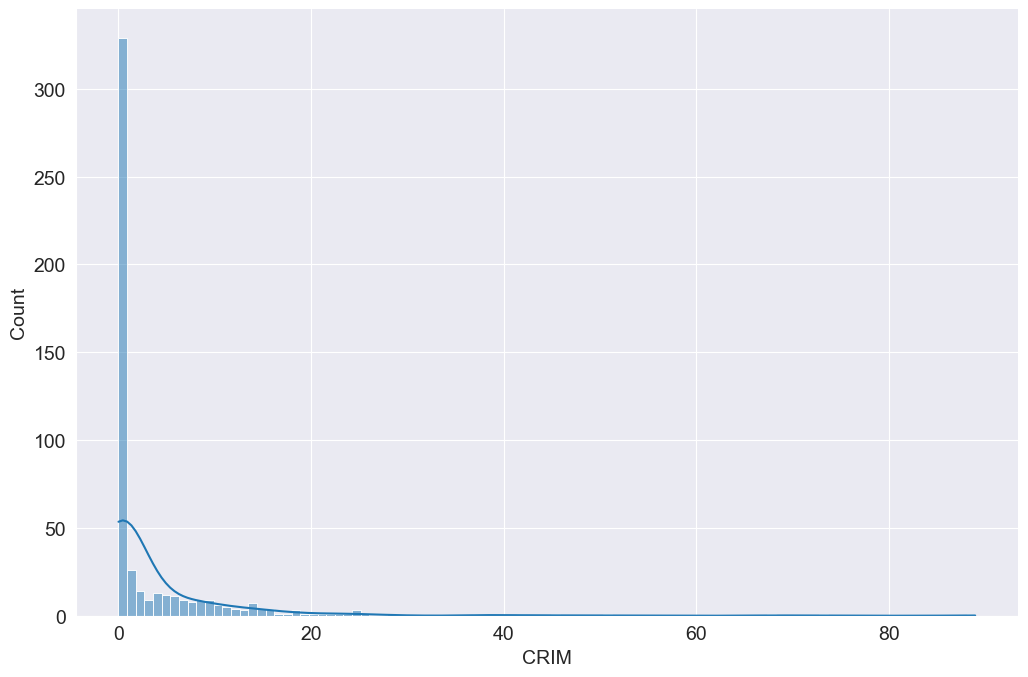

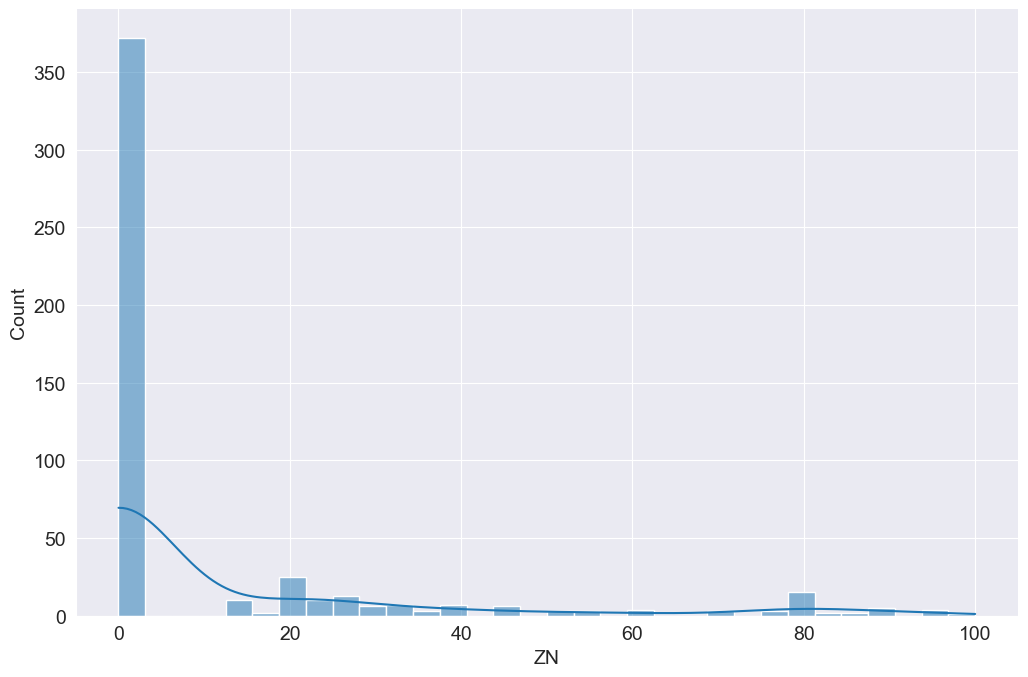

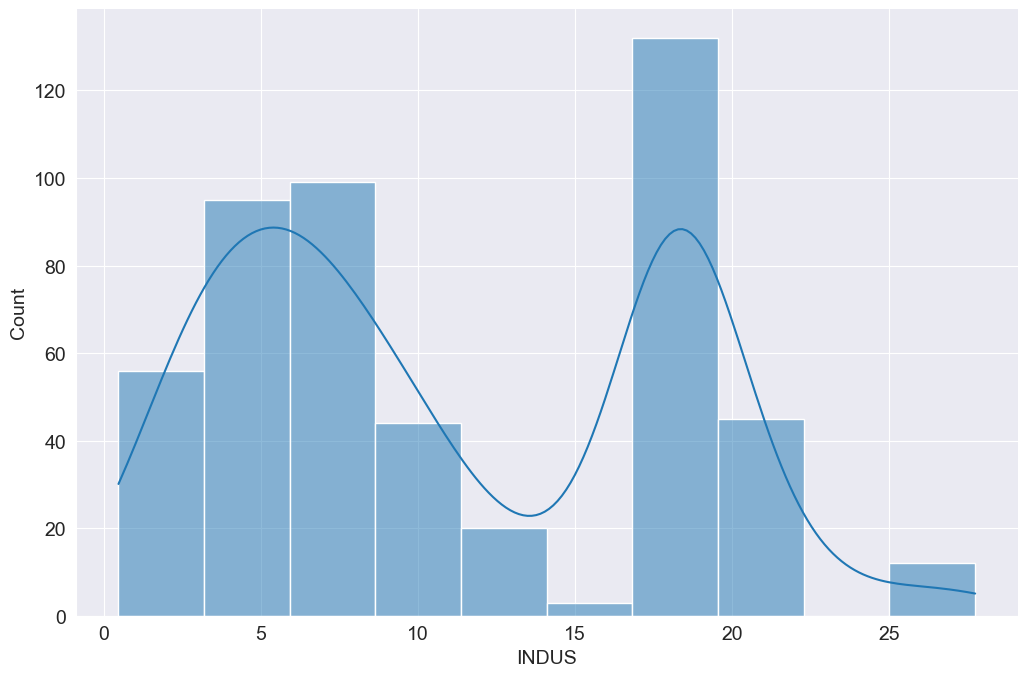

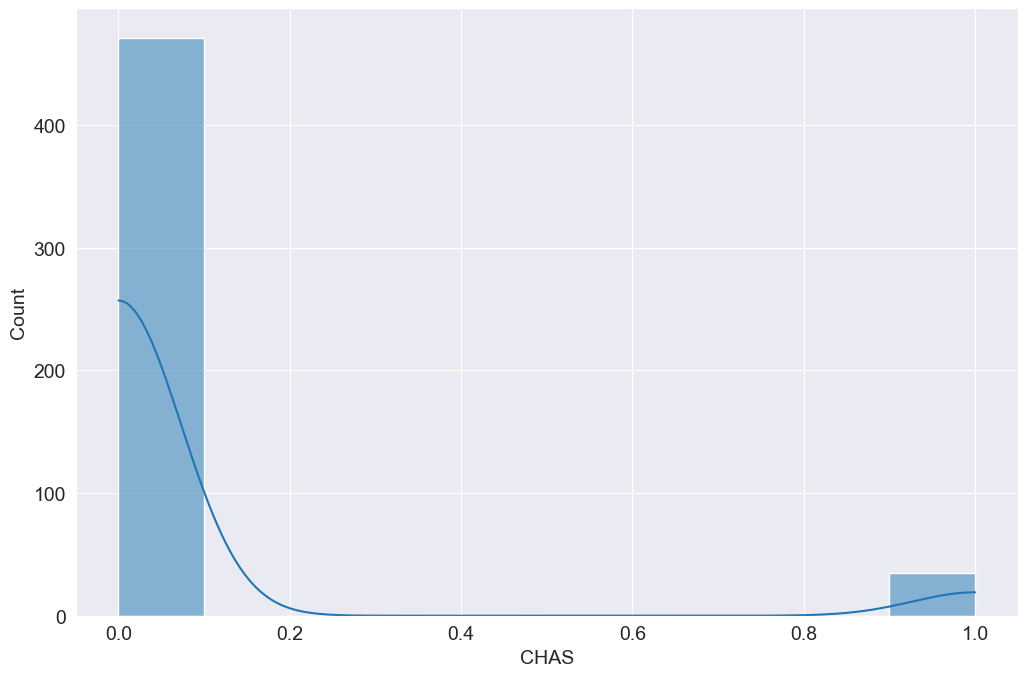

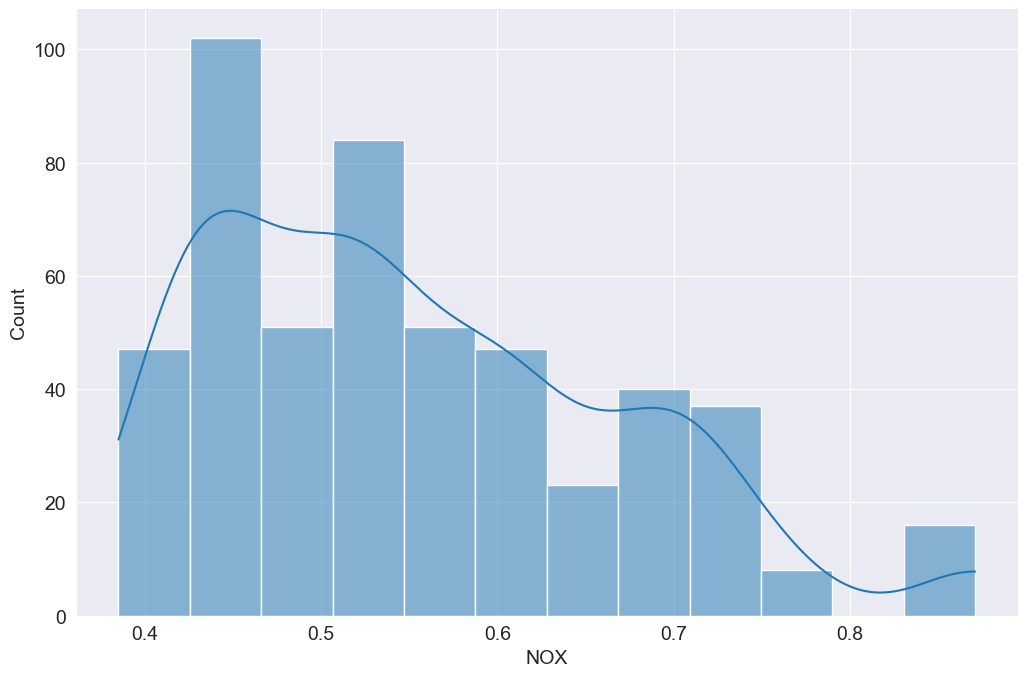

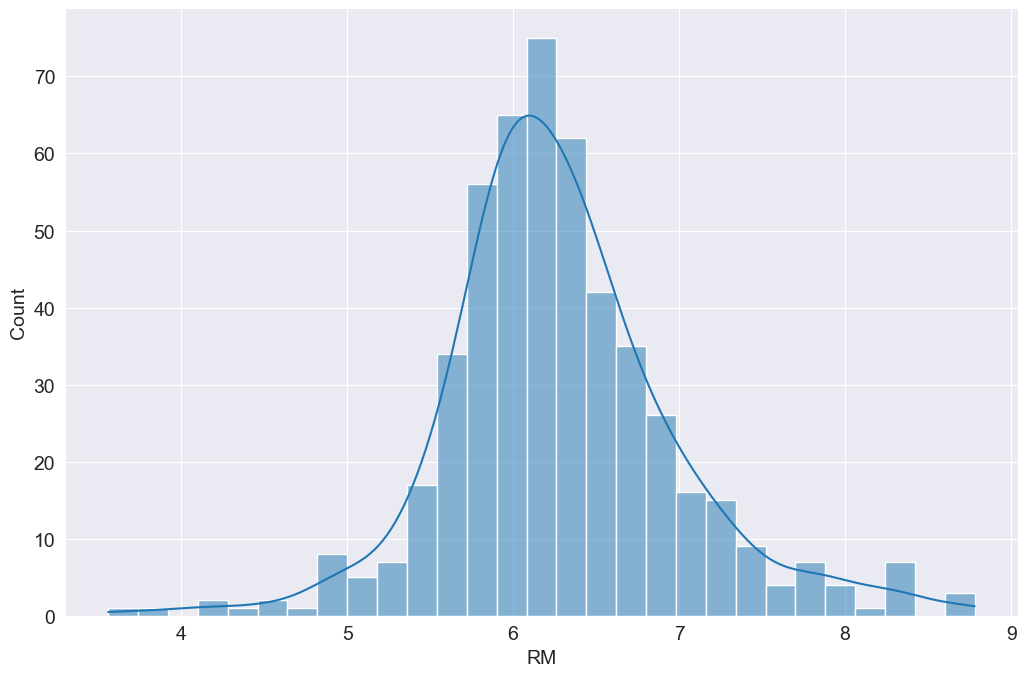

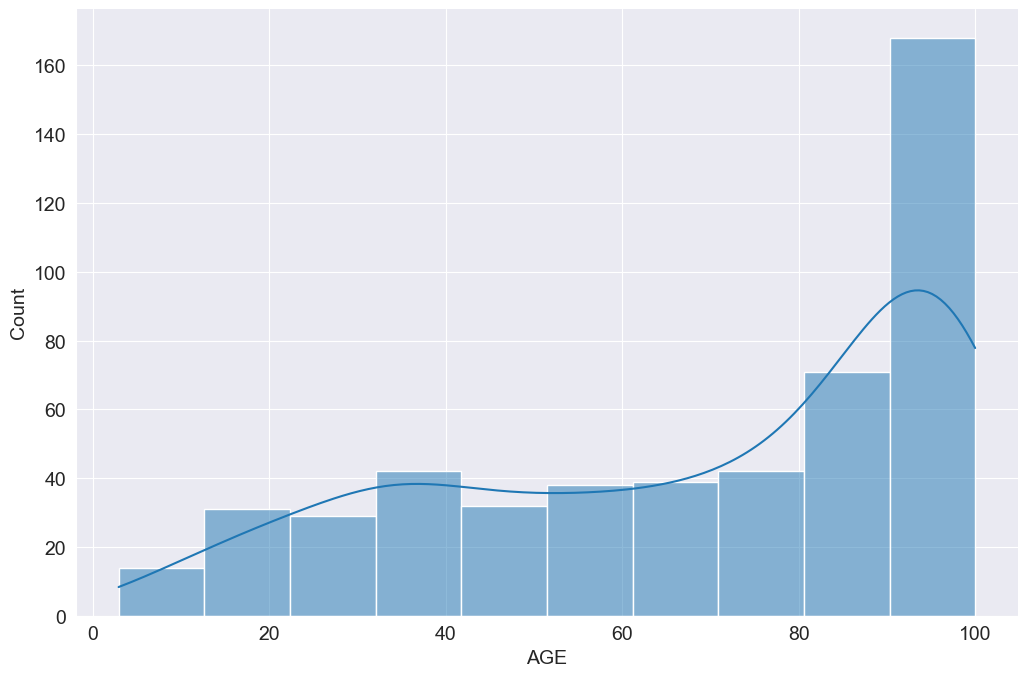

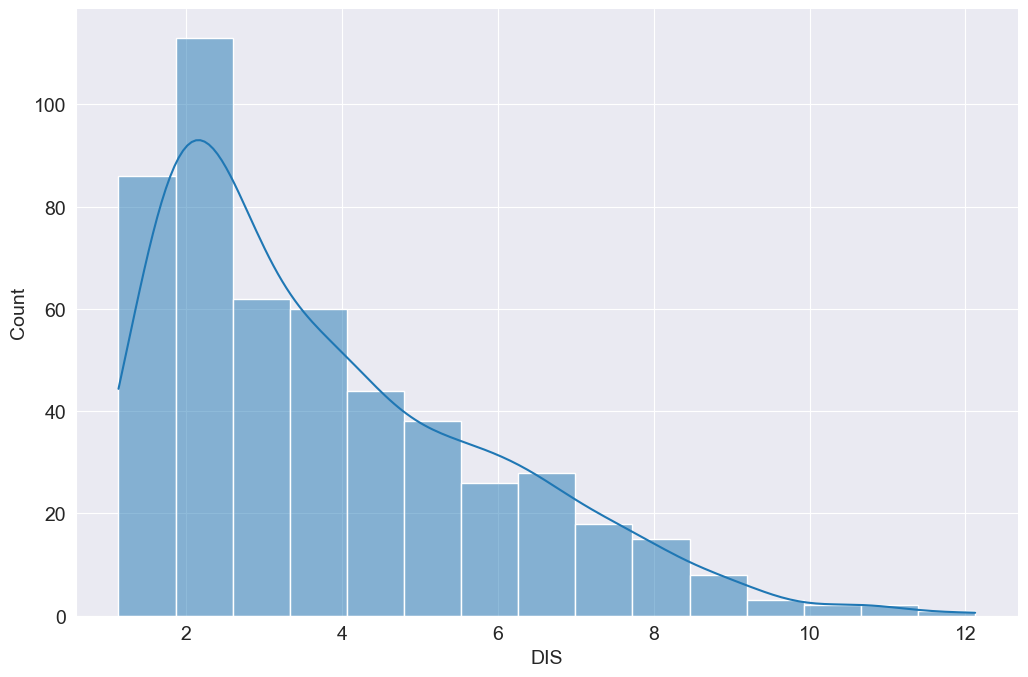

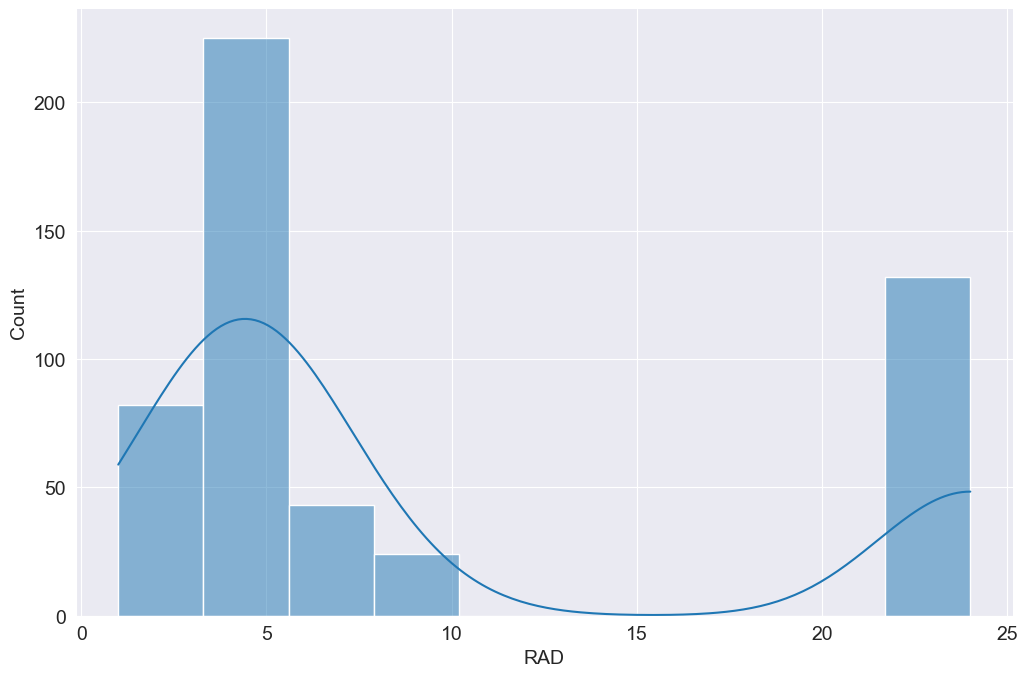

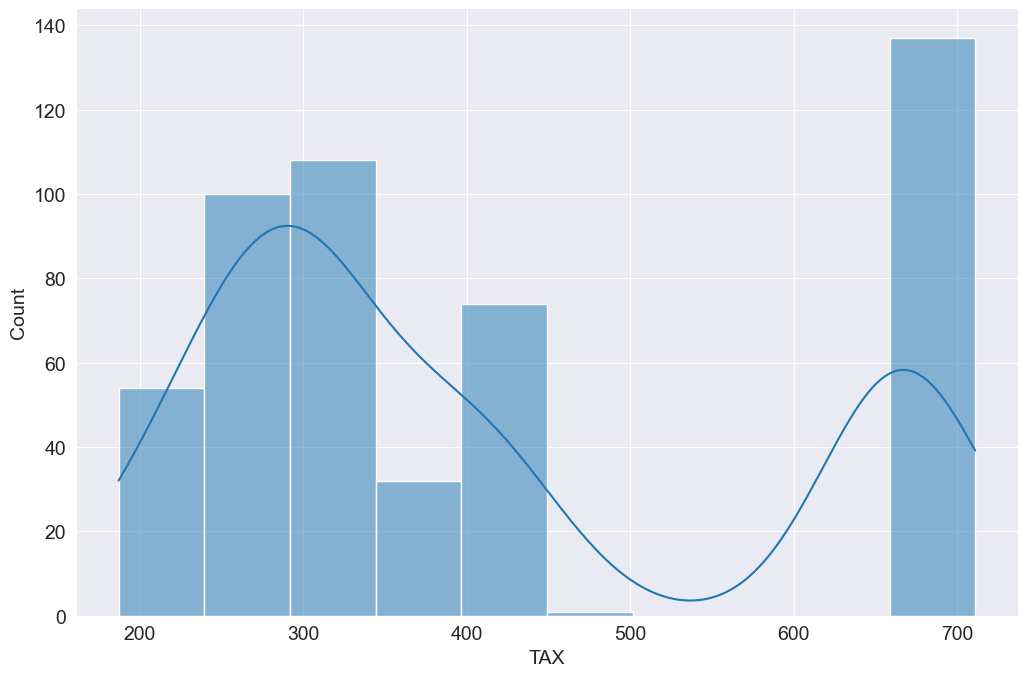

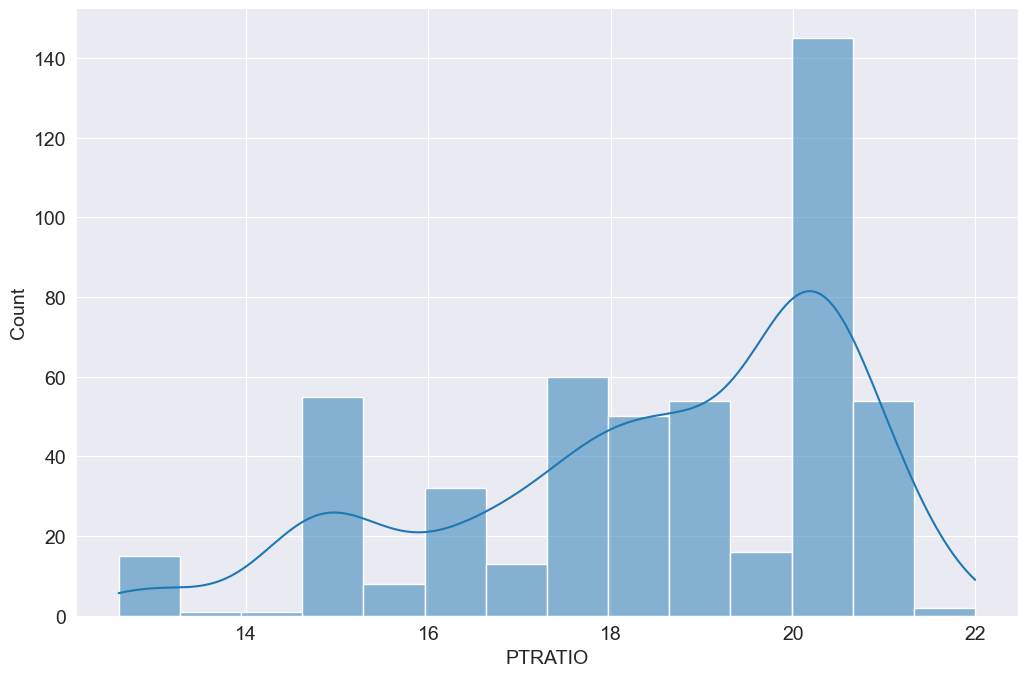

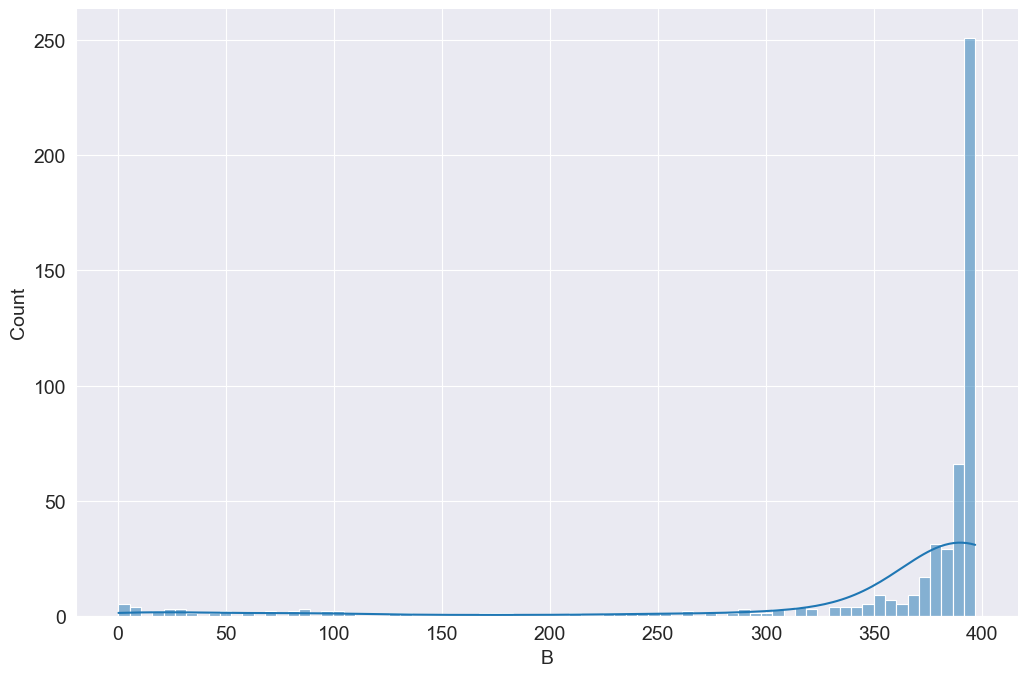

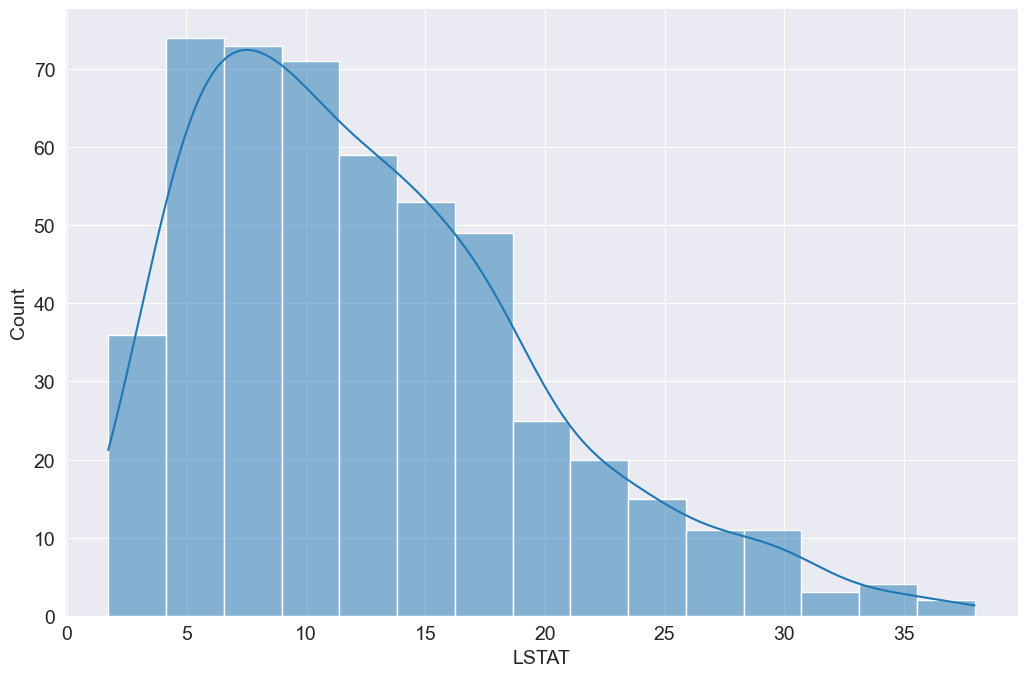

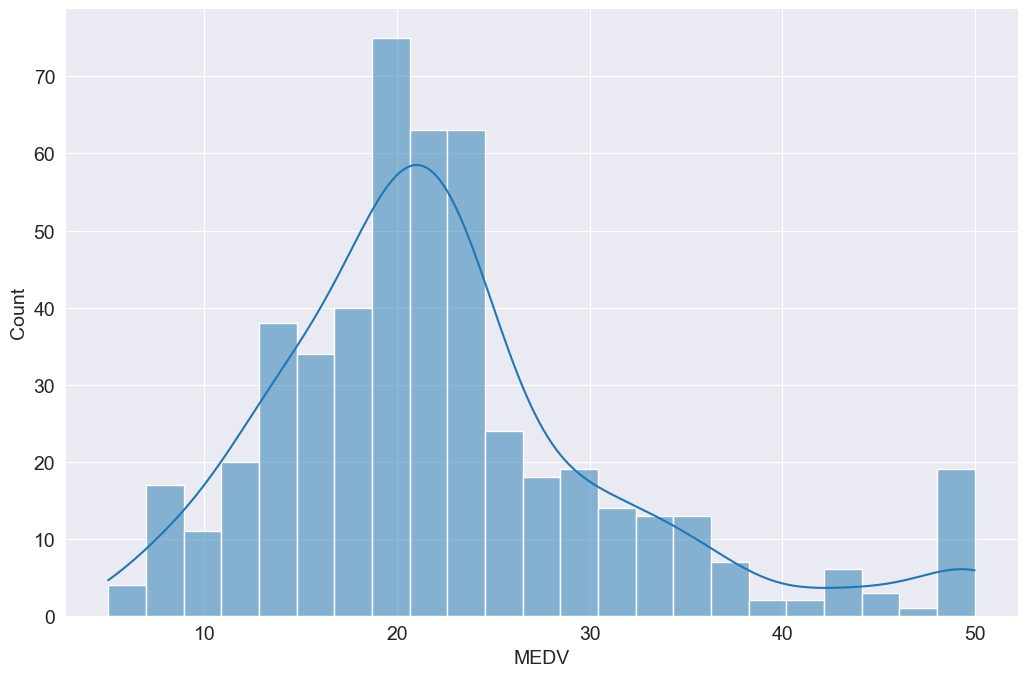

In [7]:
features=df.columns
for f, i in zip(features,np.arange(1,len(features)+1)):
    sns.displot(df[f], kde=True, height=7, aspect=1.5)
    plt.show()

Из графиков видно, что переменные NOX и DIS сдвинуты влево, а переменная AGE сдвинута вправо. CHAS является биномиальной переменной. Переменные CRIM и ZN имеют значения, которые отличаются в сотни раз, следовательно, возможно свести CRIM к биномиальному распределению, назначить порог выше которого значения переменной сделать 0, отразим это в дальнейшем в предобработке.

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')


<Axes: >

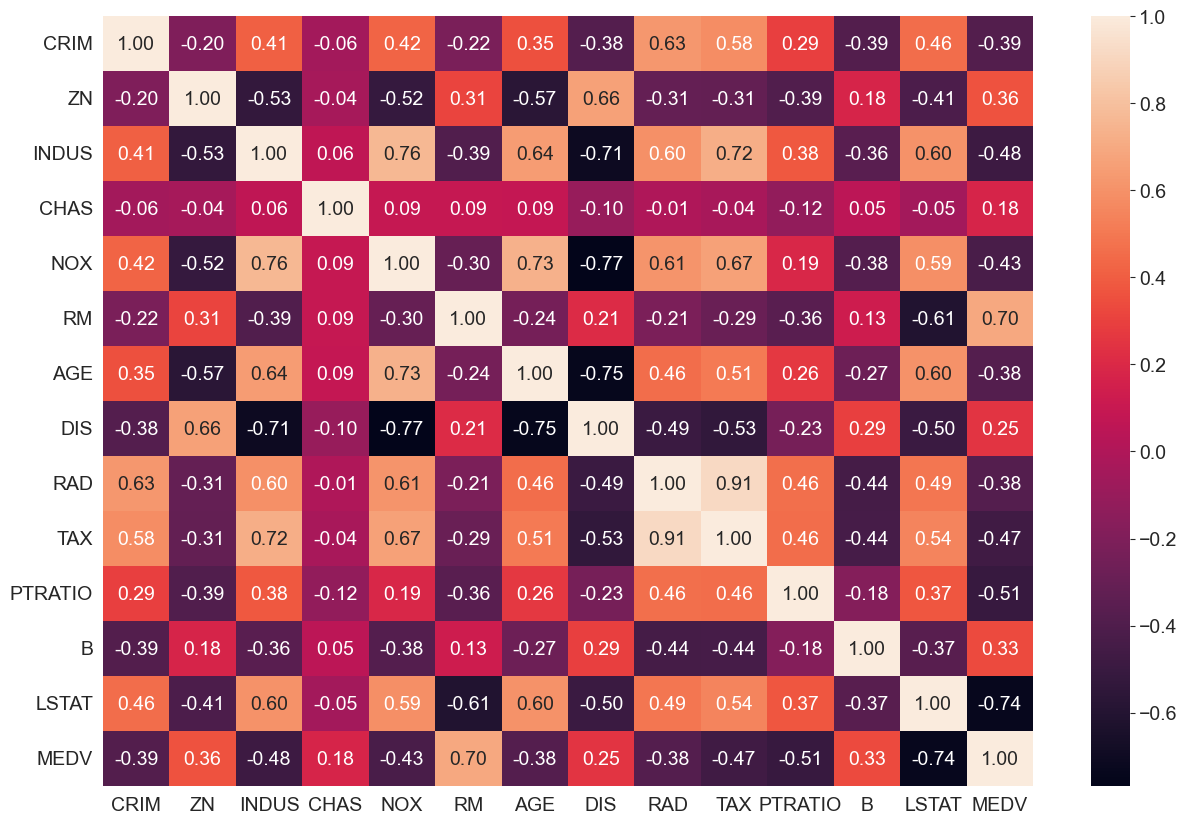

In [8]:
features=df.columns
print (features)
correlation_mtrx=df[features].corr()
sns.heatmap(correlation_mtrx, annot=True, fmt='.2f')

Исходя из матрицы корреляции можно сделать вывод, что переменные RM и LSTAT больше всего коррелируют с переменной MEDV.
Посмотрим на графическое отображение зависисмости MEDV от остальных переменных.

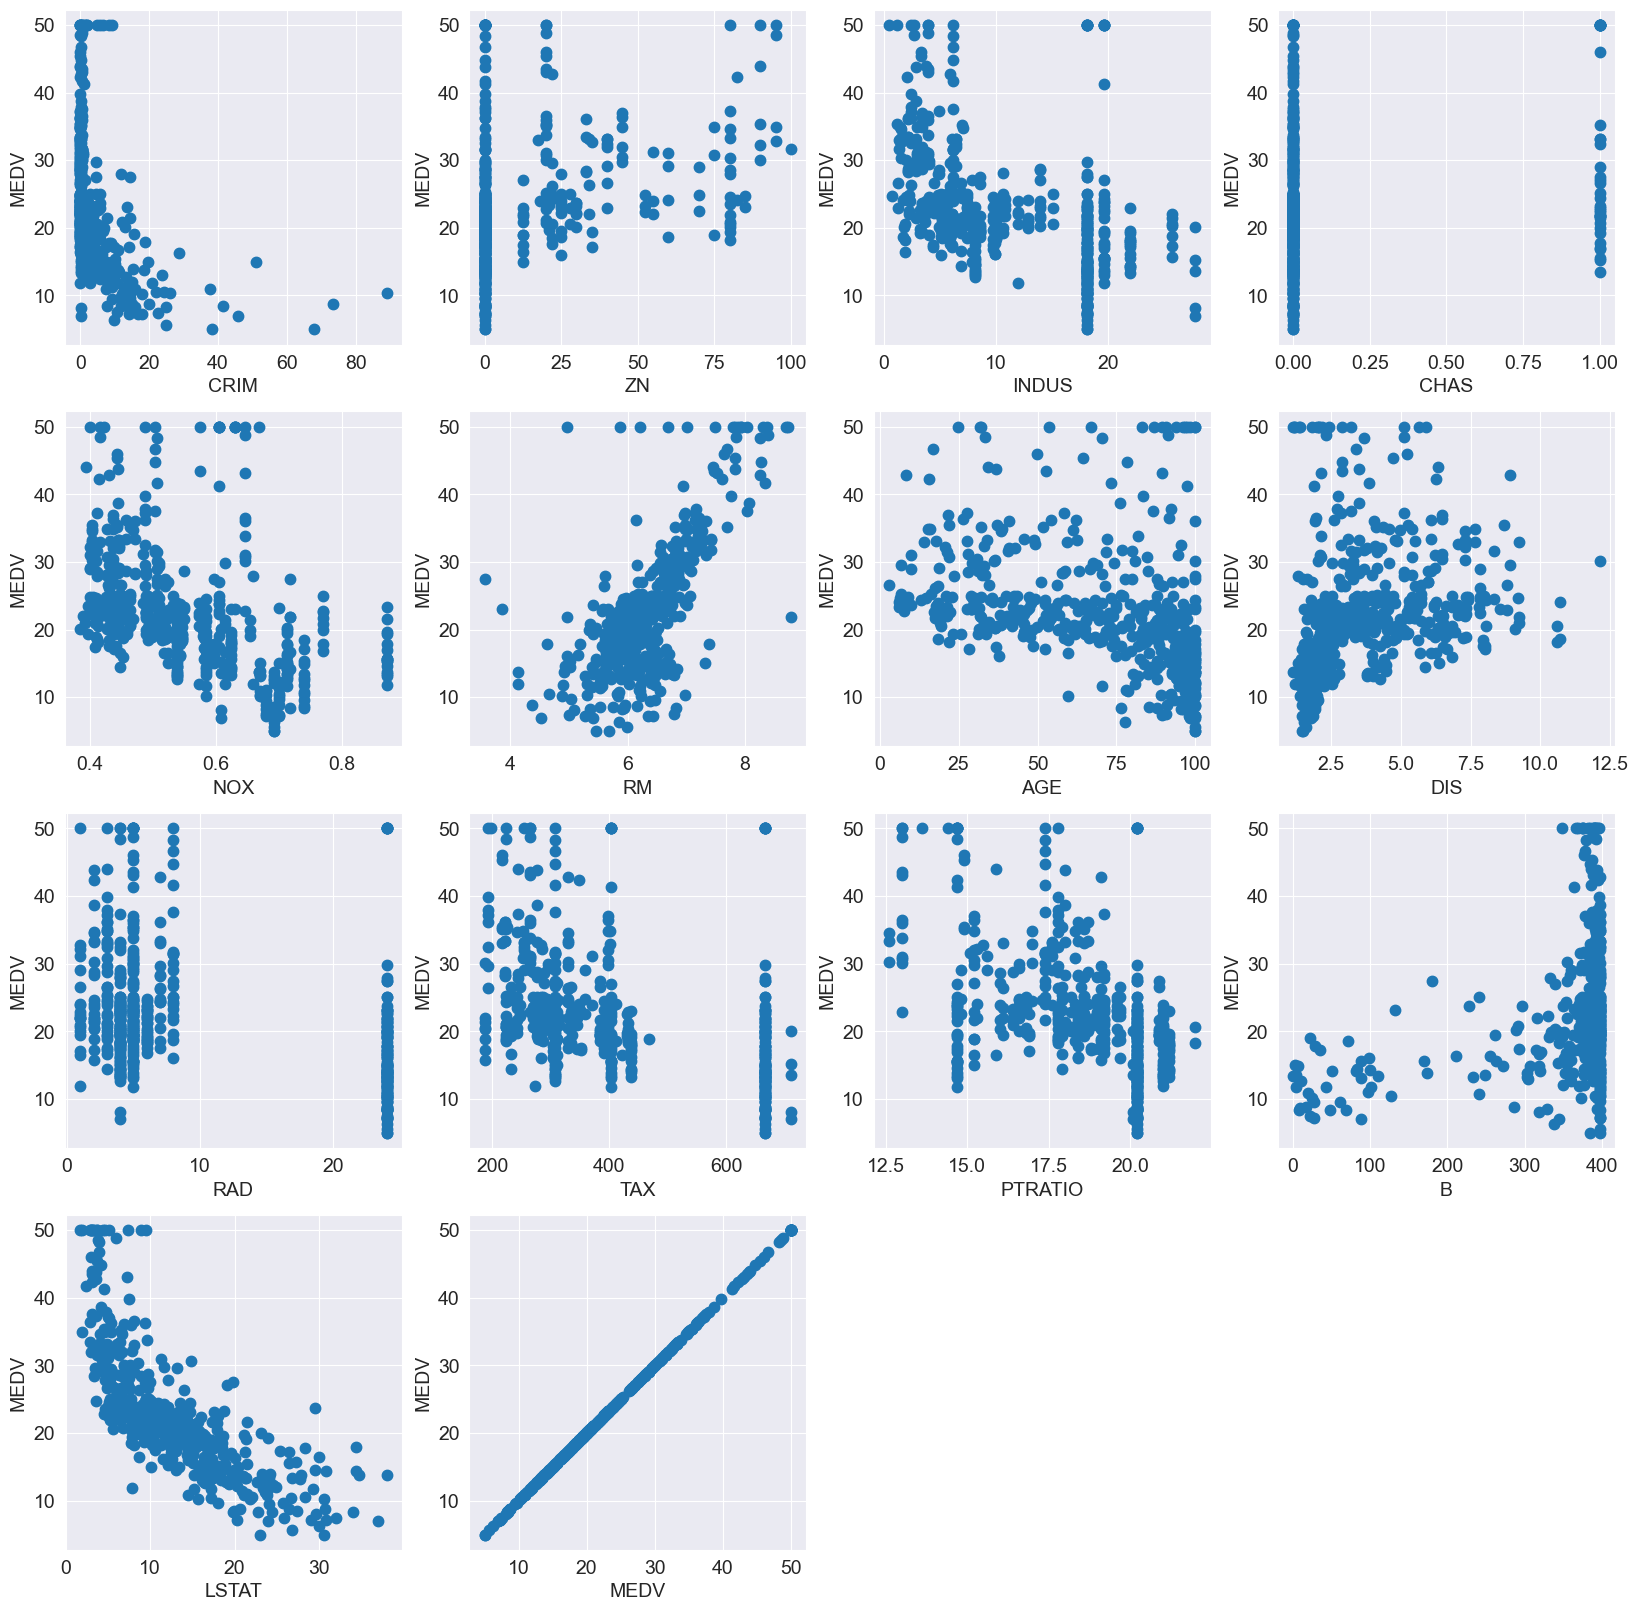

In [9]:
plt.figure(figsize=(20,20))

for f , i in zip(features,np.arange(1,len(features)+1)):
    plt.subplot(4,4,i)
    plt.scatter(df[f], df.MEDV, marker='.')
    plt.xlabel(f"{f.upper()}")
    plt.ylabel("MEDV")

Явные зависисмости прослеживаются между переменными LSTAT, RM и MEDV. LSTAT похожа на квадратичную зависимость.
В распределении переменной RM наблюдается два знаения меньше 4,которые можно посчитать за выбросы и попробовать убрать их в предобработке, также точка подозрительна на выброс в районе RM>8 и MEDV<30.
Функции для предобработки данных:

In [10]:
def preproc(df):
    df_copy=df.copy()
    df_copy['DIS_log']=np.log(df_copy['DIS'])
    df_copy=df_copy.drop(['DIS'],axis=1)
    df_copy['LSTAT_poly_2']=df_copy['LSTAT']**2

    for i in range(df_copy.shape[0]):
        if df_copy.loc[df_copy.index[i], 'CRIM'] < 0.1:
            df_copy.loc[df_copy.index[i], 'is CRIM'] = 0  
        else:  df_copy.loc[df_copy.index[i], 'is CRIM'] = 1
    
    mask1=df_copy.loc[:,'RM'] < 4
    mask2=df_copy.loc[:,'MEDV'] == 50
    mask3=(df_copy.loc[:,'MEDV'] < 30) & (df_copy.loc[:,'RM'] > 8)
    mask4=(df_copy.loc[:,'MEDV'] > 40)&(df_copy.loc[:,'INDUS'] > 15)
    ne_mask=mask1|mask2|mask3|mask4
    df_cleaned = df_copy[~ne_mask]
    return df_cleaned

def fiting(df):
    scaler = MinMaxScaler()
    df = preproc(df)
    scaler = scaler.fit(df)
    return scaler

def transforming(scaler, df):
    df = preproc(df)
    index = df.index
    column = df.columns
    df=scaler.transform(df)
    df=pd.DataFrame(data=df,index=index,columns=column)
    return df

In [11]:
df_train_data, df_test_data=train_test_split(df, test_size=0.3,random_state=RANDOM_SEED)
scaler=fiting(df_train_data)

pre_train = transforming(scaler, df_train_data)
pre_test = transforming(scaler, df_test_data)

train=pre_train.copy()
test=pre_test.copy()

model=LinearRegression()
train_data=train.pop('MEDV')
model=model.fit(train, train_data)

y_true = test.pop('MEDV')
y_pred = model.predict(test)

In [12]:
df_train_data1, df_test_data1 = train_test_split(df,test_size=0.3,random_state=RANDOM_SEED)
scaler1 = fiting(df_train_data1)

train_pre1 = transforming(scaler1, df_train_data1)
test_pre1 = transforming(scaler1, df_test_data1)

train1 = train_pre1.copy()
test1 = test_pre1.copy()

model1 = Ridge()

train_data1 = train1.pop('MEDV')

model1.fit(train1, train_data1)

y_true1 = test1.pop('MEDV')
y_pred1 = model1.predict(test1)

In [13]:
df_train_data2, df_test_data2 = train_test_split(df,test_size=0.3,random_state=RANDOM_SEED)
scaler2 = fiting(df_train_data2)

train_pre2 = transforming(scaler2, df_train_data2)
test_pre2 = transforming(scaler2, df_test_data2)

train2 = train_pre2.copy()
test2 = test_pre2.copy()

model2 = Lasso()

train_data2 = train2.pop('MEDV')

model2.fit(train2, train_data2)

y_true2 = test2.pop('MEDV')
y_pred2 = model2.predict(test2)

Анализ показателей

In [14]:
R2 = r2_score(y_true, y_pred)
MAE = mean_absolute_error(y_true, y_pred)
MSE = mean_squared_error(y_true, y_pred)
RMSE = np.sqrt(MSE)

R21 = r2_score(y_true1, y_pred1)
MAE1 = mean_absolute_error(y_true1, y_pred1)
MSE1 = mean_squared_error(y_true1, y_pred1)
RMSE1 = np.sqrt(MSE1)

R22 = r2_score(y_true2, y_pred2)
MAE2 = mean_absolute_error(y_true2, y_pred2)
MSE2 = mean_squared_error(y_true2, y_pred2)
RMSE2 = np.sqrt(MSE2)

In [15]:
data = {
    'R2': [R2,R21,R2],
    'MAE': [MAE,MAE1,MAE2],
    'MSE': [MSE,MSE1,MSE2],
    'RMSE':[RMSE,RMSE1,RMSE2]
}

pd.DataFrame(data, index=('LinearRegression','Ridge','Lasso'))

,R2,MAE,MSE,RMSE
LinearRegression,0.799316,0.054979,0.005636,0.075074
Ridge,0.768726,0.057687,0.006495,0.080593
Lasso,0.799316,0.128900,0.029137,0.170697


*LinearRegression* показывает  результаты лучше, чем *Ridge*, так как СКО, а R2 больше.
